In [1]:
class Lamp
  attr_reader :name, :room, :x, :y, :radius, :max_lumens, :max_consumption, :forgotten
  
  def initialize(name, room, x, y, height, radius, max_lumens, max_consumption)
    @name = name
    @room = room
    @x = x
    @y = y
    @height = height
    @radius = radius
    @max_lumens = max_lumens
    @max_consumption = max_consumption
    @power = 0
    @requests = []
    @forgotten = false
  end
  
  def target(x, y, aura = 0)
    @target_aura = aura
    @distance_squared = (@x - x) ** 2 + (@y - y) ** 2
#     puts "#{@room.name} | #{@name} - distance #{Math.sqrt(@distance_squared) / 46}"
  end
  
  def in_range
    @distance_squared <= (@target_aura + @radius) ** 2
  end
  
  def max_illumination
    @max_lumens / (@distance_squared / (46.0 ** 2) + @height ** 2)
  end
  
  def efficiency
    max_illumination / @max_consumption
  end
  
  def comfortability
    -@distance_squared
  end
  
  def on?
    @power != 0
  end
  
  def request(requested_illumination)
    @requests << (requested_illumination / max_illumination).clamp(0, 1)
    @requests.max * max_illumination
  end
  
  def on!
    @requests << 1
    @forgotten = false
  end
  
  def apply(forget_ratio = 0)
    new_power = @requests.max || 0
    @forgotten = true if @power == 1 && new_power == 0 && rand() < forget_ratio
    @power = new_power unless @forgotten
    @requests = []
#     puts "#{@room.name} | #{@name} - power #{@power}"
  end
  
  def consumption
    @max_consumption * @power
  end
  
  def illumination
    max_illumination * @power
  end
end

class Room
  attr_reader :name, :apartment, :top, :right, :bottom, :left, :lamps
  
  def initialize(name, apartment, top, right, bottom, left, lamps)
    @name = name
    @apartment = apartment
    @top = top
    @right = right
    @bottom = bottom
    @left = left
    @lamps = lamps.map { |l| Lamp.new(l[:name], self, l[:x], l[:y], l[:height], l[:radius], l[:max_lumens], l[:max_consumption]) }
  end
  
  def include?(x, y)
    (left..right).include?(x) && (top..bottom).include?(y)
  end
end

class Apartment
  attr_reader :width, :height, :rooms, :hall
  
  def initialize(width, height, rooms, hall_lamps)
    @height = height
    @width = width
    @rooms = rooms.map { |r| Room.new(r[:name], self, r[:top], r[:right], r[:bottom], r[:left], r[:lamps]) }
    @hall = Room.new("Hall", self, 0, width, height, 0, hall_lamps)
  end
  
  def find_room(x, y)
    return nil unless (0..width).include?(x) && (0..height).include?(y)
    @rooms.each { |room| return room if room.include?(x, y) }
    hall
  end
end

class Person
  attr_reader :name, :apartment, :room, :x, :y
  
  def initialize(name, apartment, x, y)
    @name = name
    @apartment = apartment
    @room = apartment.find_room(x, y)
    @x = x
    @y = y
  end
  
  def move!
    return if rand() < 0.3 # does not move
    
    # moves maximum 40 pixels in x and y per iteration
    @x = (@x + (rand() - 0.5) * 80).clamp(0, @apartment.width)
    @y = (@y + (rand() - 0.5) * 80).clamp(0, @apartment.height)
    
    while @x < 80 && @y > 305 do
      @x = (@x + (rand() - 0.5) * 80).clamp(0, @apartment.width)
      @y = (@y + (rand() - 0.5) * 80).clamp(0, @apartment.height)
    end
    
    @room = @apartment.find_room @x, @y
    
#     puts "#{@name} moved to (#{@x.round}, #{@y.round}) – #{@room.name}"
  end
end

:move!

In [2]:
apartment = Apartment.new(
  440,
  370,
  [
    { name: "Bathroom", top: 146, right: 140, bottom: 306, left: 0, lamps: [
      { name: "Ceiling", x: 70, y: 225, height: 2.7, radius: 105, max_lumens: 1500 , max_consumption: 20 },
      { name: "Mirror 1", x: 16, y: 207, height: 2, radius: 35, max_lumens: 2 * 470, max_consumption: 2 * 6 },
      { name: "Mirror 2", x: 16, y: 243, height: 2, radius: 35, max_lumens: 2 * 470, max_consumption: 2 * 6 },
      { name: "Rear 1", x: 44, y: 162, height: 1.6, radius: 35, max_lumens: 470 , max_consumption: 6 },
      { name: "Rear 2", x: 70, y: 162, height: 1.6, radius: 35, max_lumens: 470 , max_consumption: 6 },
      { name: "Rear 3", x: 96, y: 162, height: 1.6, radius: 35, max_lumens: 470 , max_consumption: 6 },
    ]},
    { name: "Bedroom 1", top: 146, right: 440, bottom: 252, left: 240, lamps: [
      { name: "Ceiling", x: 340, y: 200, height: 2.7, radius: 115, max_lumens: 3 * 470, max_consumption: 3 * 6.5 },
      { name: "Desk", x: 395, y: 170, height: 2, radius: 45, max_lumens: 470, max_consumption: 6 },
    ]},
    { name: "Bedroom 2", top: 252, right: 440, bottom: 370, left: 240, lamps: [
      { name: "Ceiling", x: 340, y: 310, height: 2.7, radius: 115, max_lumens: 4 * 450, max_consumption: 4 * 6 },
      { name: "Desk", x: 395, y: 270, height: 1.5, radius: 45, max_lumens: 470, max_consumption: 6 },
    ]},
  ],
  [
    { name: "Entrance", x: 155, y: 355, height: 2.7, radius: 160, max_lumens: 2 * 500, max_consumption: 2 * 7 },
    { name: "Corridor", x: 190, y: 230, height: 2.7, radius: 100, max_lumens: 3 * 470, max_consumption: 3 * 6.5 },
    { name: "Living room 1", x: 125, y: 70, height: 2.7, radius: 135, max_lumens: 2000, max_consumption: 25 },
    { name: "Living room 2", x: 325, y: 70, height: 2.7, radius: 135, max_lumens: 2000, max_consumption: 25 },
    { name: "Floor lamp", x: 400, y: 30, height: 2, radius: 60, max_lumens: 800, max_consumption: 15 },
    { name: "Kitchen 1", x: 16, y: 40, height: 1.6, radius: 45, max_lumens: 400, max_consumption: 6 },
    { name: "Kitchen 2", x: 16, y: 105, height: 1.6, radius: 45, max_lumens: 470, max_consumption: 60 },
  ]
)
puts "OK"

OK


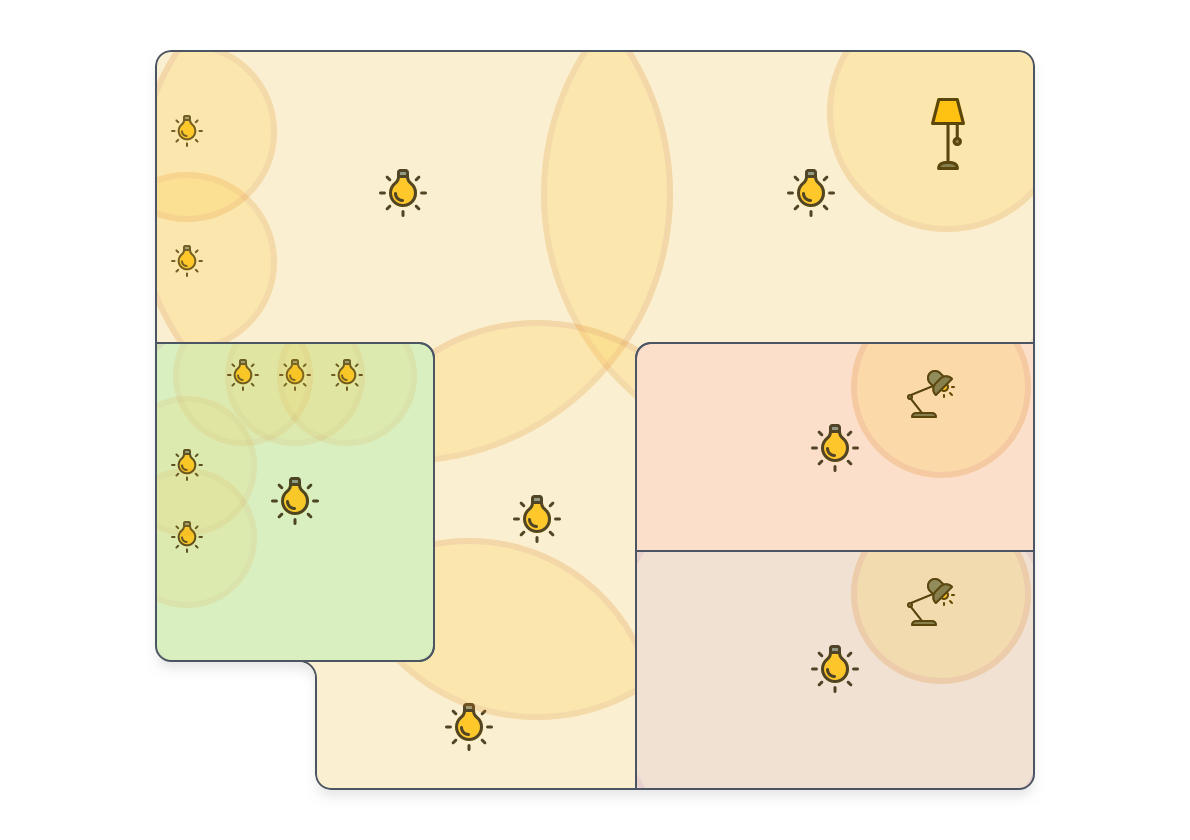

In [3]:
def test(method, iterations, apartment, people)
  samples = []
  iterations.times do
    samples << method.call(apartment, people)
  end
  samples.sum / iterations
end

:test

## Power saving

Uses algorithm that decides which lamps to turn on based on their efficiency over distance

Assures area near user will have luminocity of 150 lux

Each person has 1m activation radius

In [4]:
power_saving_iteration = proc do |apartment, people|
  desired_illumination = 150
  
  people.each do |person|
    person.move!
    nearby_lamps = person.room.lamps.each { |lamp| lamp.target(person.x, person.y, 45) }.filter(&:in_range).sort_by(&:efficiency)
    
    illumination = desired_illumination
    while !nearby_lamps.empty?
      total_efficiency = nearby_lamps.map(&:efficiency).inject(:+)
      lamp = nearby_lamps.shift
      illumination -= lamp.request(illumination * lamp.efficiency / total_efficiency)
    end
    puts "Not enough light! #{illumination} more lux needed (#{person.x.round}, #{person.y.round})" if illumination > 60
  end
  (apartment.rooms + [apartment.hall]).map(&:lamps).flatten.each(&:apply).map(&:consumption).inject(:+)
end

#<Proc:0x00007fae48148f90 (irb):0>

### Power saving single

In [5]:
people_single = [Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2)]
puts people_single.map(&:name)
test(power_saving_iteration, 18000, apartment, people_single)

Ernest Khalimov


17.792434869115027

### Power saving two

In [6]:
people_two = [
  Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Alisher Morgenshtern", apartment, apartment.width / 2, apartment.height / 2)
]
puts people_two.map(&:name)
test(power_saving_iteration, 18000, apartment, people_two)

Ernest Khalimov
Alisher Morgenshtern


33.088933389019545

### Power saving three

In [7]:
people_three = [
  Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Alisher Morgenshtern", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Joe Biden", apartment, apartment.width / 2, apartment.height / 2)
]
puts people_three.map(&:name)
test(power_saving_iteration, 18000, apartment, people_three)

Ernest Khalimov
Alisher Morgenshtern
Joe Biden


44.75224270143772

## Comfortable

Uses algorithm that decides which lamps to turn on based on their comfortability (distance from the user)

Assures area near user will have luminocity of 150 lux

Each person has 3m activation radius

In [8]:
comfortable_iteration = proc do |apartment, people|
  desired_illumination = 150
  
  people.each do |person|
    person.move!
    nearby_lamps = person.room.lamps.each { |lamp| lamp.target(person.x, person.y, 135) }.filter(&:in_range).sort_by(&:comfortability)
    
    illumination = desired_illumination
    while !nearby_lamps.empty?
      total_comfortability = nearby_lamps.map(&:comfortability).inject(:+)
      lamp = nearby_lamps.shift
      illumination -= lamp.request(illumination * lamp.comfortability / total_comfortability)
    end
    puts "Not enough light! #{illumination.round} more lux needed (#{person.x.round}, #{person.y.round})" if illumination > 20
  end
  (apartment.rooms + [apartment.hall]).map(&:lamps).flatten.each(&:apply).map(&:consumption).inject(:+)
end

#<Proc:0x00007fae200c4ee8 (irb):0>

### Comfortable single

In [9]:
people_single = [Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2)]
puts people_single.map(&:name)
test(comfortable_iteration, 18000, apartment, people_single)

Ernest Khalimov


35.82136869097936

### Comfortable two

In [10]:
people_two = [
  Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Alisher Morgenshtern", apartment, apartment.width / 2, apartment.height / 2)
]
puts people_two.map(&:name)
test(comfortable_iteration, 18000, apartment, people_two)

Ernest Khalimov
Alisher Morgenshtern


62.36284292380649

### Comfortable three

In [11]:
people_three = [
  Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Alisher Morgenshtern", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Joe Biden", apartment, apartment.width / 2, apartment.height / 2)
]
puts people_three.map(&:name)
test(comfortable_iteration, 18000, apartment, people_three)

Ernest Khalimov
Alisher Morgenshtern
Joe Biden


84.07359021536968

## Ordinary careful

Users turn on the lights near them, not forgetting to turn them off

In [12]:
ordinary_careful_iteration = proc do |apartment, people|
  people.each do |person|
    person.move!
    person.room.lamps.each { |lamp| lamp.target(person.x, person.y, 90) }.filter(&:in_range).map(&:on!)
  end
  (apartment.rooms + [apartment.hall]).map(&:lamps).flatten.each(&:apply).map(&:consumption).inject(:+)
end

#<Proc:0x00007fae20933a98 (irb):0>

### Ordinary careful single

In [13]:
people_single = [Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2)]
puts people_single.map(&:name)
test(ordinary_careful_iteration, 18000, apartment, people_single)

Ernest Khalimov


55.85330555555556

### Ordinary careful two

In [14]:
people_two = [
  Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Alisher Morgenshtern", apartment, apartment.width / 2, apartment.height / 2)
]
puts people_two.map(&:name)
test(ordinary_careful_iteration, 18000, apartment, people_two)

Ernest Khalimov
Alisher Morgenshtern


98.58752777777778

### Ordinary careful three

In [15]:
people_three = [
  Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Alisher Morgenshtern", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Joe Biden", apartment, apartment.width / 2, apartment.height / 2)
]
puts people_three.map(&:name)
test(ordinary_careful_iteration, 18000, apartment, people_three)

Ernest Khalimov
Alisher Morgenshtern
Joe Biden


130.17983333333333

## Ordinary

Users turn on the lights near them with a **10% chance** to forget to turn them off (more realistic scenario)

In [16]:
ordinary_iteration = proc do |apartment, people|
  people.each do |person|
    person.move!
    person.room.lamps.each { |lamp| lamp.target(person.x, person.y, 90) }.filter(&:in_range).map(&:on!)
  end
  (apartment.rooms + [apartment.hall]).map(&:lamps).flatten.each { |lamp| lamp.apply(0.1) }.map(&:consumption).inject(:+)
end

#<Proc:0x00007fae37919de8 (irb):0>

### Ordinary single

In [17]:
people_single = [Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2)]
puts people_single.map(&:name)
test(ordinary_iteration, 18000, apartment, people_single)

Ernest Khalimov


71.34033333333333

### Ordinary two

In [18]:
people_two = [
  Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Alisher Morgenshtern", apartment, apartment.width / 2, apartment.height / 2)
]
puts people_two.map(&:name)
test(ordinary_iteration, 18000, apartment, people_two)

Ernest Khalimov
Alisher Morgenshtern


109.83822222222223

### Ordinary three

In [19]:
people_three = [
  Person.new("Ernest Khalimov", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Alisher Morgenshtern", apartment, apartment.width / 2, apartment.height / 2),
  Person.new("Joe Biden", apartment, apartment.width / 2, apartment.height / 2)
]
puts people_three.map(&:name)
test(ordinary_iteration, 18000, apartment, people_three)

Ernest Khalimov
Alisher Morgenshtern
Joe Biden


141.425